## Prediction using Deep FF (64 hidden layers)

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import Dataset, DataLoader

In [3]:
force1=pd.read_csv('FlowStress_Prediction.csv')

In [4]:
force1['strain']=np.log(force1['sch_entry_thickness']/force1['sch_exit_thickness'])
force1['strain_rate']=force1['strain']*force1['meas_speed_fpm']/np.sqrt(0.5*force1['avgrolldiam']*(force1['sch_entry_thickness']-force1['sch_exit_thickness']))
force1['ln_strain']=np.log(force1['strain'])
force1['ln_strain_rate']=np.log(force1['strain_rate'])
force1['core_temp']=force1['meas_entry_temp']+5/9*0.75*force1['model_target_gauge']*(force1['meas_entry_temp']**4/308300000000+(force1['meas_entry_temp']-70)**1.25/1412)
R=8.314
force1['1/RT']=1/(R*force1['core_temp'])

In [5]:
a=force1.loc[force1['model_grade']=='01010095FH1 ']

In [6]:
a = a.dropna(subset=['1/RT'])

In [7]:
RT= a['1/RT']
strain_rate = a['strain_rate']
measured_values = a['meas_flow_stress']
temp=a['core_temp']

In [8]:
input_features = a[['strain_rate', 'core_temp','meas_flow_stress']].values

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(a[['strain_rate', 'core_temp','meas_flow_stress']])

# Define train-test split (80-20) to be used layer
train_size = int(0.8 * len(scaled_data))
test_size = len(scaled_data) - train_size
train_data, test_data = scaled_data[0:train_size,:], scaled_data[train_size:len(scaled_data),:]

In [9]:
# Convert to PyTorch tensor
x_train = torch.tensor(scaled_data, dtype=torch.float32)

In [10]:
# Define the neural network model
class ZenerHollomonModel(nn.Module):
    def __init__(self):
        super(ZenerHollomonModel, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(3, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 3) 
        )

    def forward(self, x):
        return self.fc(x)


In [11]:
# Define the loss function and optimizer
model = ZenerHollomonModel()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
# Training the model
num_epochs = 2500
for epoch in range(num_epochs):
    optimizer.zero_grad()
    outputs = model(x_train)
    
    
    target_coefficients = torch.tensor(a['meas_flow_stress'].values).float().view(-1,1)
    
    loss = criterion(outputs, target_coefficients)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 100 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')


C:\Users\SDEY\AppData\Local\anaconda3\envs\pyt-env\Lib\site-packages\torch\nn\modules\loss.py:535: UserWarning: Using a target size (torch.Size([164, 1])) that is different to the input size (torch.Size([164, 3])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


Epoch [100/2500], Loss: 5.0427
Epoch [200/2500], Loss: 1.5986
Epoch [300/2500], Loss: 0.8905
Epoch [400/2500], Loss: 0.5056
Epoch [500/2500], Loss: 0.3125
Epoch [600/2500], Loss: 0.2015
Epoch [700/2500], Loss: 0.1284
Epoch [800/2500], Loss: 0.0624
Epoch [900/2500], Loss: 0.0177
Epoch [1000/2500], Loss: 0.0029
Epoch [1100/2500], Loss: 0.0015
Epoch [1200/2500], Loss: 0.0013
Epoch [1300/2500], Loss: 0.0011
Epoch [1400/2500], Loss: 0.0010
Epoch [1500/2500], Loss: 0.0009
Epoch [1600/2500], Loss: 0.0008
Epoch [1700/2500], Loss: 0.0007
Epoch [1800/2500], Loss: 0.0006
Epoch [1900/2500], Loss: 0.0005
Epoch [2000/2500], Loss: 0.0004
Epoch [2100/2500], Loss: 0.0003
Epoch [2200/2500], Loss: 0.0003
Epoch [2300/2500], Loss: 0.0002
Epoch [2400/2500], Loss: 0.0002
Epoch [2500/2500], Loss: 0.0002


In [13]:
# Use the model for prediction
with torch.no_grad():
    predicted_coefficients = model(x_train)
   
    
# Denormalize the predictions
predicted_values = scaler.inverse_transform(predicted_coefficients)


In [14]:
print(predicted_values[:,2])

[ 26.33195834  49.84714293  72.11621532  77.96715779  80.91789484
  83.81406698  87.73876238  92.6150157   97.5148674  107.28774395
  70.26995854  78.94921045  32.31869791  61.56683998  78.92119951
  83.00891895  87.6885869   89.64444065  94.52096224  98.44562988
 103.32569447 113.11878366  75.11650343  81.86205225  38.1270458
  80.87197466  82.90308237  87.67828169  89.64743786  94.51500483
  99.42424593 104.30209961 114.09541082  76.08985586  82.83615398
  39.09393897  65.487886    76.99256115  78.95436769  83.80390978
  85.76610947  89.66592064  94.56531906 100.42394419 109.23222866
  72.20479484  80.89398193  39.92204015  70.26807141  79.20664654
  82.07379942  87.69571915  94.55824232 100.44029932 112.16949215
  69.30614352  76.04739542  44.69439721  74.96712408  81.83919392
  85.88144646  90.62039251  98.45196657 105.30312996 116.05463181
  72.22005377  79.93381629  63.55051041  77.96452136  80.98952255
  85.77189112  92.6114542   97.51076012 108.27092981  67.36181145
  74.106550

In [15]:
print(measured_values)

19881      2.4
19882      4.9
19883      7.2
19884      7.8
19885      8.1
          ... 
130532    10.2
130533    10.9
130534    12.1
130535     7.3
130536     8.1
Name: meas_flow_stress, Length: 164, dtype: float64


In [16]:
print(predicted_coefficients[:,2])

tensor([ 2.4672,  4.8915,  7.1872,  7.7904,  8.0946,  8.3932,  8.7978,  9.3005,
         9.8057, 10.8132,  6.9969,  7.8917,  3.0844,  6.0997,  7.8888,  8.3102,
         8.7926,  8.9943,  9.4970,  9.9016, 10.4047, 11.4143,  7.4965,  8.1920,
         3.6832,  8.0899,  8.2993,  8.7916,  8.9946,  9.4964, 10.0025, 10.5054,
        11.5150,  7.5969,  8.2924,  3.7829,  6.5039,  7.6900,  7.8922,  8.3922,
         8.5944,  8.9965,  9.5016, 10.1056, 11.0136,  7.1964,  8.0922,  3.8683,
         6.9967,  7.9182,  8.2138,  8.7934,  9.5008, 10.1072, 11.3164,  6.8975,
         7.5925,  4.3602,  7.4811,  8.1896,  8.6063,  9.0949,  9.9023, 10.6086,
        11.7170,  7.1979,  7.9932,  6.3042,  7.7902,  8.1020,  8.5950,  9.3001,
         9.8052, 10.9145,  6.6971,  7.3924,  3.0285,  5.8915,  7.3963,  7.7978,
         8.2993,  9.0043,  9.5082, 10.6166,  6.4986,  7.2939,  3.8880,  7.1880,
         8.1903,  8.5920,  8.9965,  9.8034, 10.4091, 11.6139,  7.0994,  7.7938,
         4.2860,  7.6605,  8.5914,  8.89

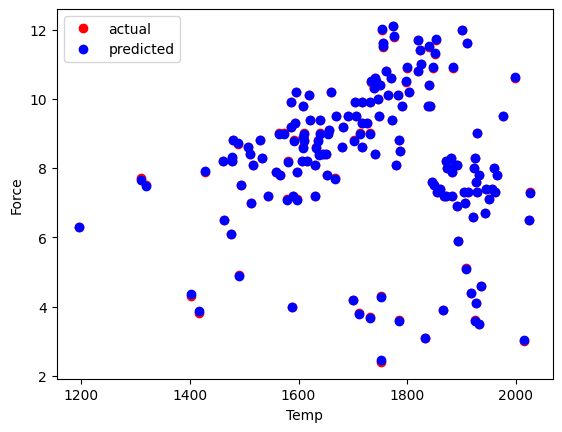

In [17]:
plt.plot(a['core_temp'],measured_values,'ro',label='actual')
plt.plot(a['core_temp'],predicted_coefficients[:,2],'bo',label='predicted')
plt.xlabel('Temp')
plt.ylabel('Force')
plt.legend()
plt.show()

## Loss : 0.0002

With the same number of epochs, we get better loss as compared to a straight-forward FFN.
Introducing the hidden layers captures the non-linearity much better. 
- Next step would be splitting the data into train-test data 